In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# Load dataset

In [4]:
headers = ['text','id', 'subreddit', 'meta', 'time', 'author', 'ups', 'downs', 'authorlinkkarma', 'authorkarma', 'authorisgold']
# reddit.columns = headers

In [138]:
reddit = pd.read_csv('comments.csv', names= headers, date_parser=['time'])  # header=None

# Preprocess

In [139]:
# delete comments with NaN text
reddit = reddit[reddit['text'].notna()]

In [140]:
# drop duplicates -- turns out that there are a lot of duplicated rows
reddit = reddit.drop_duplicates()

# EDA

In [141]:
reddit.shape

(97929, 11)

In [142]:
reddit.describe()

,time,ups,downs,authorlinkkarma,authorkarma,authorisgold
count,9.792900e+04,97929.000000,97929.0,9.792100e+04,9.792100e+04,88615.000000
mean,1.455394e+09,53.935106,0.0,5.128443e+03,1.755740e+04,0.089928
std,1.731083e+06,264.842723,0.0,6.021745e+04,6.161786e+04,0.286081
min,1.400891e+09,-164.000000,0.0,0.000000e+00,-1.000000e+02,0.000000
25%,1.455559e+09,1.000000,0.0,1.000000e+00,3.280000e+02,0.000000
50%,1.455629e+09,4.000000,0.0,1.060000e+02,2.913000e+03,0.000000
75%,1.455656e+09,16.000000,0.0,1.476000e+03,1.347400e+04,0.000000
max,1.455688e+09,6453.000000,0.0,5.650077e+06,2.220594e+06,1.000000


In [10]:
reddit.downs.unique()

array([0.])

### A few initial observations about the data:
* No comments have any downvotes. --> This feature could be excluded. 
* Most authors are not gold users.
* 'Gaming' is the topic that users seem to be most actively posting comments. 

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

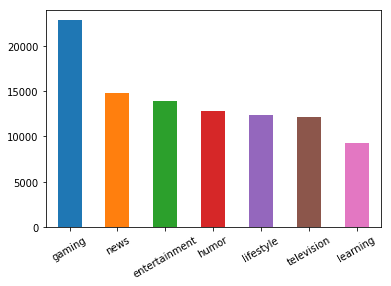

In [29]:
reddit.meta.value_counts().plot.bar()
plt.xticks(rotation=30)

# Feature engineering

### Number of links in the comment

In [143]:
reddit['num_link'] = reddit['text'].str.count('http') + reddit['text'].str.count('https')

In [13]:
# Now remove all the links out of the text


In [106]:
# # p_link = re.compile("https? : //([\w_-]+(?:(?:\.[\w_-]+)+)([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-]*))?")
# p_link = re.compile('(https? : \/\/)(\s)?(www\.)?(\s?)(\w+\.)*([\w\-\s]+\/)*([\w-]+)+\/?\s?')


In [137]:
# text = "easonable : http : //www.nytimes.com/1987/11/12/us/reagan-nominates-anthony-kennedy-to-supreme-court.html ? pagewanted = all equally ridiculous , here 's a 1970 law review article in which mcconnell argues for presidential dominion in the supreme court nomination process http : //imgur.com/pbeveod"
# result = p_link.findall(text)
# print(result)

[('http : //', '', 'www.', '', 'nytimes.', 'us/', 'reagan-nominates-anthony-kennedy-to-supreme-court'), ('http : //', '', '', '', 'imgur.', 'com/', 'pbeveod')]


In [112]:
# for element in result[0]:
#     text = text.replace(element, '')
# text

"easonable : com/1987/11/12/.html ? pagewanted = all equally ridiculous , here 's a 1970 law review article in which mcconnell argues for presidential dominion in the supreme court nomination process imgur.com/pbeveod"

In [122]:
# text.replace(':','')
# text

"easonable : com/1987/11/12/.html ? pagewanted = all equally ridiculous , here 's a 1970 law review article in which mcconnell argues for presidential dominion in the supreme court nomination process imgur.com/pbeveod"

### Word count

In [152]:
# remove punctuations
reddit.text = reddit.text.str.replace('[.,?!;:]', '')

In [153]:
reddit['word_count'] = reddit['text'].str.split().str.len()

In [154]:
reddit.word_count.max()

10000

(array([1.400e+01, 1.627e+03, 2.377e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 9.998e+03, 9.999e+03,
        1.000e+04]),
 <a list of 10000 Patch objects>)

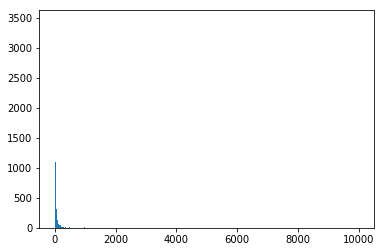

In [33]:
plt.hist(x=reddit['word_count'], bins=10000)

__Note__: Most comments seem to have less than 400 words but there are some dubiously long comments. --> Outliers to remove. Will treat them separately.

In [34]:
reddit_long = reddit[reddit.word_count >= 400]
reddit = reddit[reddit.word_count < 400]

(array([7.3080e+03, 1.2709e+04, 1.2746e+04, 1.0361e+04, 8.1420e+03,
        6.2430e+03, 5.0490e+03, 3.9790e+03, 3.3070e+03, 2.6230e+03,
        2.5120e+03, 1.9680e+03, 1.6800e+03, 1.5320e+03, 1.3740e+03,
        1.2100e+03, 1.1010e+03, 1.0960e+03, 9.0300e+02, 7.1100e+02,
        6.7400e+02, 6.4800e+02, 5.9800e+02, 5.2200e+02, 4.3500e+02,
        4.3300e+02, 4.0000e+02, 4.1500e+02, 3.3200e+02, 2.6600e+02,
        3.3000e+02, 3.0800e+02, 2.5700e+02, 1.9900e+02, 2.6000e+02,
        2.4500e+02, 2.2600e+02, 2.1700e+02, 1.9400e+02, 1.9100e+02,
        1.8000e+02, 1.6100e+02, 1.4300e+02, 1.4400e+02, 1.1300e+02,
        1.3700e+02, 1.1700e+02, 1.6200e+02, 9.4000e+01, 8.7000e+01,
        8.0000e+01, 7.7000e+01, 7.6000e+01, 8.8000e+01, 5.8000e+01,
        6.1000e+01, 6.5000e+01, 6.4000e+01, 7.2000e+01, 6.8000e+01,
        5.8000e+01, 5.8000e+01, 4.3000e+01, 6.7000e+01, 5.6000e+01,
        4.9000e+01, 3.6000e+01, 7.5000e+01, 5.4000e+01, 5.6000e+01,
        3.4000e+01, 3.7000e+01, 5.4000e+01, 4.30

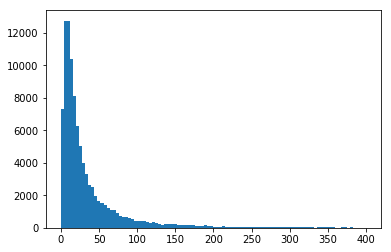

In [35]:
plt.hist(x=reddit['word_count'], bins=100)

### Word count categorical
Based on this distribution, we'll discretize comments based on word count into 4 groups: short, medium, long, and very long comments.

In [44]:
# bins = pd.IntervalIndex.from_tuples([(0, 50), (50, 100), (100, 400)])
# reddit['word_count_cat'] = pd.cut(reddit['word_count'], bins, labels=['short', 'medium', 'long'])
bins = pd.IntervalIndex.from_tuples([(0, 25), (25, 50), (50, 100), (100, 400)])
reddit['word_count_cat'] = pd.cut(reddit['word_count'], bins, labels=['short', 'medium', 'long', 'very long'])

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

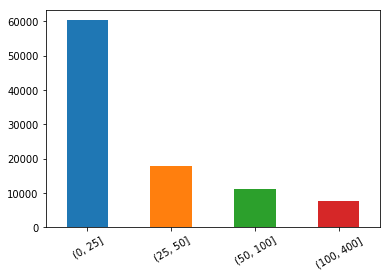

In [45]:
reddit.word_count_cat.value_counts().plot.bar()
plt.xticks(rotation=30)

### Subjectivity

In [155]:
reddit['subjectivity'] = reddit['text'].str.count('i ')

__Question__: Why are weird duplicates that `drop_duplicates` couldn't get rid of?

In [156]:
reddit = reddit.drop_duplicates()

In [157]:
reddit.shape

(97929, 15)

In [158]:
reddit[reddit.subjectivity == 32]

,text,id,subreddit,meta,time,author,ups,downs,authorlinkkarma,authorkarma,authorisgold,num_link,sentence_count,word_count,subjectivity
415682,my journey began on april 4 2015 i had extrem...,d00rve2,progresspics,lifestyle,1.455554e+09,SwinginCrabWhacka,32.0,0.0,566.0,15176.0,0.0,0,388,351,32
472125,my journey began on april 4 2015 i had extrem...,d00rve2,progresspics,lifestyle,1.455554e+09,SwinginCrabWhacka,33.0,0.0,566.0,15176.0,0.0,0,388,351,32
574945,my journey began on april 4 2015 i had extrem...,d00rve2,progresspics,lifestyle,1.455554e+09,SwinginCrabWhacka,35.0,0.0,566.0,15176.0,0.0,0,388,351,32
649423,my journey began on april 4 2015 i had extrem...,d00rve2,progresspics,lifestyle,1.455554e+09,SwinginCrabWhacka,31.0,0.0,566.0,15176.0,0.0,0,388,351,32
2148885,i feel you the game 's not fun anymore for me ...,d01vlky,dota2,gaming,1.455632e+09,da7thsin,8.0,0.0,4.0,3339.0,0.0,0,514,489,32
2251322,i feel you the game 's not fun anymore for me ...,d01vlky,dota2,gaming,1.455632e+09,da7thsin,6.0,0.0,4.0,3339.0,0.0,0,514,489,32
2347976,i feel you the game 's not fun anymore for me ...,d01vlky,dota2,gaming,1.455632e+09,da7thsin,7.0,0.0,4.0,3339.0,0.0,0,514,489,32


(array([7.8739e+04, 8.8370e+03, 3.8030e+03, 2.0970e+03, 1.1450e+03,
        7.4000e+02, 4.0900e+02, 3.2200e+02, 2.0800e+02, 1.4300e+02,
        1.5300e+02, 9.5000e+01, 1.1100e+02, 7.6000e+01, 4.2000e+01,
        9.2000e+01, 1.9000e+01, 1.6000e+01, 3.2000e+01, 9.0000e+00,
        2.0000e+01, 1.3000e+01, 5.0000e+00, 2.0000e+00, 6.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([ 0.        ,  1.06666667,  2.13333333,  3.2       ,  4.26666667,
         5.33333333,  6.4       ,  7.46666667,  8.53333333,  9.6       ,
        10.66666667, 11.73333333, 12.8       , 13.86666667, 14.93333333,
        16.        , 17.06666667, 18.13333333, 19.2       , 20.26666667,
        21.33333333, 22.4       , 23.46666667, 24.53333333, 25.6       ,
        26.66666667, 27.73333333, 28.8       , 29.86666667, 30.93333333,
        32.        ]),
 <a list of 30 Patch objects>)

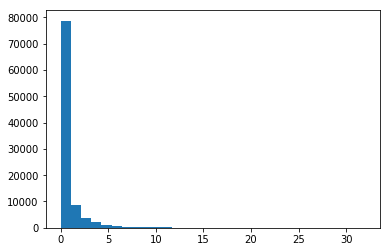

In [56]:
plt.hist(reddit.subjectivity, bins=30)

### Number of unique words

In [159]:
reddit.head(5)

,text,id,subreddit,meta,time,author,ups,downs,authorlinkkarma,authorkarma,authorisgold,num_link,sentence_count,word_count,subjectivity
4,disclaimer i think obama should nominate some...,d028c5d,politics,news,1.455651e+09,degausse,3.0,0.0,1.0,1941.0,0.0,0,101,93,1
6,either way the process will be dragged out unt...,d026od6,politics,news,1.455648e+09,cyberspyder,5.0,0.0,1300.0,6462.0,1.0,0,47,47,0
7,republicans have always battled with severe ca...,d026wk3,politics,news,1.455649e+09,jabb0,15.0,0.0,44981.0,141501.0,0.0,0,10,10,0
8,politics were so different back then people on...,d02a3k3,politics,news,1.455653e+09,Hypertension123456,2.0,0.0,46.0,42036.0,0.0,1,25,23,0
9,equally ridiculous here 's a 1970 law review ...,d025wad,politics,news,1.455647e+09,trash_reason,26.0,0.0,5613.0,1361.0,0.0,1,25,24,0


# Model fitting

In [165]:
y = reddit.ups
x = reddit.drop(axis=1, columns='ups')

In [170]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

## Linear Regression

In [161]:
from sklearn.model_selection import train_test_split

In [171]:
X_train.head(5)

,text,id,subreddit,meta,time,author,downs,authorlinkkarma,authorkarma,authorisgold,num_link,sentence_count,word_count,subjectivity
73867,not gon na lie man even as a conservative i h...,d02pxvy,conservative,news,1.455676e+09,RedOctober28,0.0,1566.0,3122.0,0.0,0,39,37,1
2160247,i can see what you 're going for i assume that...,d01370m,pokemon,gaming,1.455571e+09,yourenotthebossame,0.0,0.0,0.0,NaN,0,75,72,4
796823,from the video description &gt the pws plasm...,d00vkld,space,learning,1.455560e+09,Sail_Etna,0.0,2203.0,129.0,0.0,0,448,425,1
34,what a fucking loser,d01tknu,offbeat,news,1.455627e+09,wildebeestsandangels,0.0,730.0,37620.0,0.0,0,4,4,0
1076999,well is they,d02si4m,funny,humor,1.455680e+09,cheeeeeese,0.0,0.0,0.0,NaN,0,3,3,0
